# Project: Investigate a Dataset - Gun Background Check Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset contains gun background check data from the FBI's National Instant Criminal Background Check System (NICS). The data includes monthly records for each state (and some territories) with various transaction types including:

- **month**: Date in YYYY-MM format
- **state**: State or territory name
- **permit**: Number of permits issued
- **permit_recheck**: Number of permit rechecks
- **handgun**: Number of handgun transactions
- **long_gun**: Number of long gun transactions
- **other**: Number of other firearm type transactions
- **multiple**: Number of multiple firearm type transactions
- **admin**: Administrative transactions
- **prepawn_handgun/long_gun/other**: Prepawn transactions by type
- **redemption_handgun/long_gun/other**: Redemption transactions by type
- **returned_handgun/long_gun/other**: Returned transactions by type
- **rentals_handgun/long_gun**: Rental transactions by type
- **private_sale_handgun/long_gun/other**: Private sale transactions by type
- **return_to_seller_handgun/long_gun/other**: Return to seller transactions by type
- **totals**: Total number of transactions for that month/state

### Question(s) for Analysis

1. **What are the trends in gun background checks over time?** (Dependent: totals, Independent: month)
2. **Which states have the highest and lowest gun background check rates?** (Dependent: totals, Independent: state)
3. **What is the relationship between permits issued and actual gun sales?** (Dependent: handgun + long_gun, Independent: permit)
4. **Are there seasonal patterns in gun background checks?** (Dependent: totals, Independent: month/season) 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Magic word to display visualizations inline
%matplotlib inline

# Set style for better-looking plots
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define reusable function for creating standardized plots
def create_labeled_plot(x, y, title, xlabel, ylabel, plot_type='line', **kwargs):
    """
    Create standardized plots with consistent formatting.
    
    This function helps avoid repetitive code by providing a consistent way
    to create plots with titles and axis labels, which are required for all visualizations.
    
    Args:
        x: x-axis data (array-like)
        y: y-axis data (array-like)
        title: Plot title (string)
        xlabel: x-axis label (string)
        ylabel: y-axis label (string)
        plot_type: Type of plot ('line', 'bar', 'barh', 'scatter')
        **kwargs: Additional plot parameters (figsize, color, alpha, linewidth, s, etc.)
    
    Returns:
        None (displays the plot)
    """
    # Set figure size (default or from kwargs)
    figsize = kwargs.get('figsize', (12, 6))
    plt.figure(figsize=figsize)
    
    # Create the appropriate plot type
    if plot_type == 'line':
        plt.plot(x, y, linewidth=kwargs.get('linewidth', 2), 
                color=kwargs.get('color', 'steelblue'))
    elif plot_type == 'bar':
        plt.bar(x, y, color=kwargs.get('color', 'coral'), 
               alpha=kwargs.get('alpha', 0.7))
        # Handle x-axis rotation for bar charts if needed
        if kwargs.get('rotate_x', False):
            plt.xticks(rotation=kwargs.get('x_rotation', 45), ha='right')
    elif plot_type == 'barh':
        plt.barh(x, y, color=kwargs.get('color', 'steelblue'), 
                alpha=kwargs.get('alpha', 0.7))
        # Invert y-axis for horizontal bar charts
        plt.gca().invert_yaxis()
    elif plot_type == 'scatter':
        plt.scatter(x, y, alpha=kwargs.get('alpha', 0.5), 
                   s=kwargs.get('s', 50), color=kwargs.get('color', 'steelblue'))
    
    # Add standardized labels and title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add grid
    grid_axis = kwargs.get('grid_axis', 'both')
    plt.grid(True, alpha=0.3, axis=grid_axis)
    
    # Apply tight layout and show
    plt.tight_layout()
    plt.show()


<a id='wrangling'></a>
## Data Wrangling

In this section, we will load the data, check for cleanliness, and clean the dataset for analysis.

### General Properties

In [2]:
# Load the data
df = pd.read_csv('gun_data.csv')

# Display first few rows
print("First 5 rows:")
print(df.head())
print("\n" + "="*80 + "\n")

# Check the size of the dataframe
print(f"Dataframe shape: {df.shape}")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print("\n" + "="*80 + "\n")

# Check data types
print("Data types:")
print(df.dtypes)
print("\n" + "="*80 + "\n")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\n" + "="*80 + "\n")

# Get basic statistics
print("Basic statistics:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print("\n" + "="*80 + "\n")

# Check unique values in key columns
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Date range: {df['month'].min()} to {df['month'].max()}")
print(f"Unique months: {df['month'].nunique()}")


First 5 rows:
     month       state   permit  permit_recheck  handgun  long_gun   other  \
0  2017-09     Alabama  16717.0             0.0   5734.0    6320.0   221.0   
1  2017-09      Alaska    209.0             2.0   2320.0    2930.0   219.0   
2  2017-09     Arizona   5069.0           382.0  11063.0    7946.0   920.0   
3  2017-09    Arkansas   2935.0           632.0   4347.0    6063.0   165.0   
4  2017-09  California  57839.0             0.0  37165.0   24581.0  2984.0   

   multiple  admin  prepawn_handgun  ...  returned_other  rentals_handgun  \
0       317    0.0             15.0  ...             0.0              0.0   
1       160    0.0              5.0  ...             0.0              0.0   
2       631    0.0             13.0  ...             0.0              0.0   
3       366   51.0             12.0  ...             0.0              0.0   
4         0    0.0              0.0  ...             0.0              0.0   

   rentals_long_gun  private_sale_handgun  private_sal


### Data Cleaning

Based on the initial inspection, we need to:
1. Convert the 'month' column to datetime format for easier time-based analysis
2. Check for any negative values or data inconsistencies
3. Verify that totals match the sum of individual transaction types
4. Handle any missing or zero values appropriately
 

In [3]:
# Convert month column to datetime
df['month'] = pd.to_datetime(df['month'])

# Extract year and month for easier analysis
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df['month_name'] = df['month'].dt.strftime('%B')

# Check for negative values (which shouldn't exist for counts)
numeric_cols = df.select_dtypes(include=[np.number]).columns
negative_values = (df[numeric_cols] < 0).sum()
print("Columns with negative values:")
print(negative_values[negative_values > 0])
print("\n" + "="*80 + "\n")

# Check if totals column matches sum of transaction types
# Note: totals might include all transaction types, so we'll verify
transaction_cols = ['handgun', 'long_gun', 'other', 'multiple', 'admin', 
                    'prepawn_handgun', 'prepawn_long_gun', 'prepawn_other',
                    'redemption_handgun', 'redemption_long_gun', 'redemption_other',
                    'returned_handgun', 'returned_long_gun', 'returned_other',
                    'rentals_handgun', 'rentals_long_gun',
                    'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other',
                    'return_to_seller_handgun', 'return_to_seller_long_gun', 'return_to_seller_other']

# Calculate sum of all transaction types
df['calculated_total'] = df[transaction_cols].sum(axis=1)

# Check difference between totals and calculated_total
df['total_diff'] = df['totals'] - df['calculated_total']
print(f"Rows where totals don't match sum: {(df['total_diff'] != 0).sum()}")
print(f"Maximum difference: {df['total_diff'].abs().max()}")
print(f"Mean difference: {df['total_diff'].abs().mean():.2f}")

# Display a sample of rows with differences
if (df['total_diff'] != 0).any():
    print("\nSample rows with differences:")
    print(df[df['total_diff'] != 0][['month', 'state', 'totals', 'calculated_total', 'total_diff']].head(10))

# Create a clean dataframe for analysis
# We'll keep the original totals column as it's the official count
df_clean = df.copy()

# Fill any NaN values with 0 (assuming missing means no transactions)
df_clean = df_clean.fillna(0)

print("\n" + "="*80 + "\n")
print("Data cleaning complete!")
print(f"Final dataframe shape: {df_clean.shape}")
print(f"Date range: {df_clean['month'].min()} to {df_clean['month'].max()}")


Columns with negative values:
Series([], dtype: int64)


Rows where totals don't match sum: 7729
Maximum difference: 522188.0
Mean difference: 6504.03

Sample rows with differences:
       month                 state  totals  calculated_total  total_diff
0 2017-09-01               Alabama   32019           15302.0     16717.0
1 2017-09-01                Alaska    6303            6092.0       211.0
2 2017-09-01               Arizona   28394           22943.0      5451.0
3 2017-09-01              Arkansas   17747           14180.0      3567.0
4 2017-09-01            California  123506           65667.0     57839.0
5 2017-09-01              Colorado   35873           31517.0      4356.0
6 2017-09-01           Connecticut   12117            7101.0      5016.0
7 2017-09-01              Delaware    3502            3227.0       275.0
8 2017-09-01  District of Columbia      61              60.0         1.0
9 2017-09-01               Florida   77390           66606.0     10784.0


Data cleaning

<a id='eda'></a>
## Exploratory Data Analysis

Now that we've cleaned the data, we'll explore it to answer our research questions. We'll compute statistics and create visualizations to understand trends and relationships in the data.

### Research Question 1: What are the trends in gun background checks over time?

Monthly Background Check Statistics:
Mean monthly checks: 1,187,765
Median monthly checks: 1,023,080
Min monthly checks: 21,176
Max monthly checks: 3,308,199
Standard deviation: 567,721


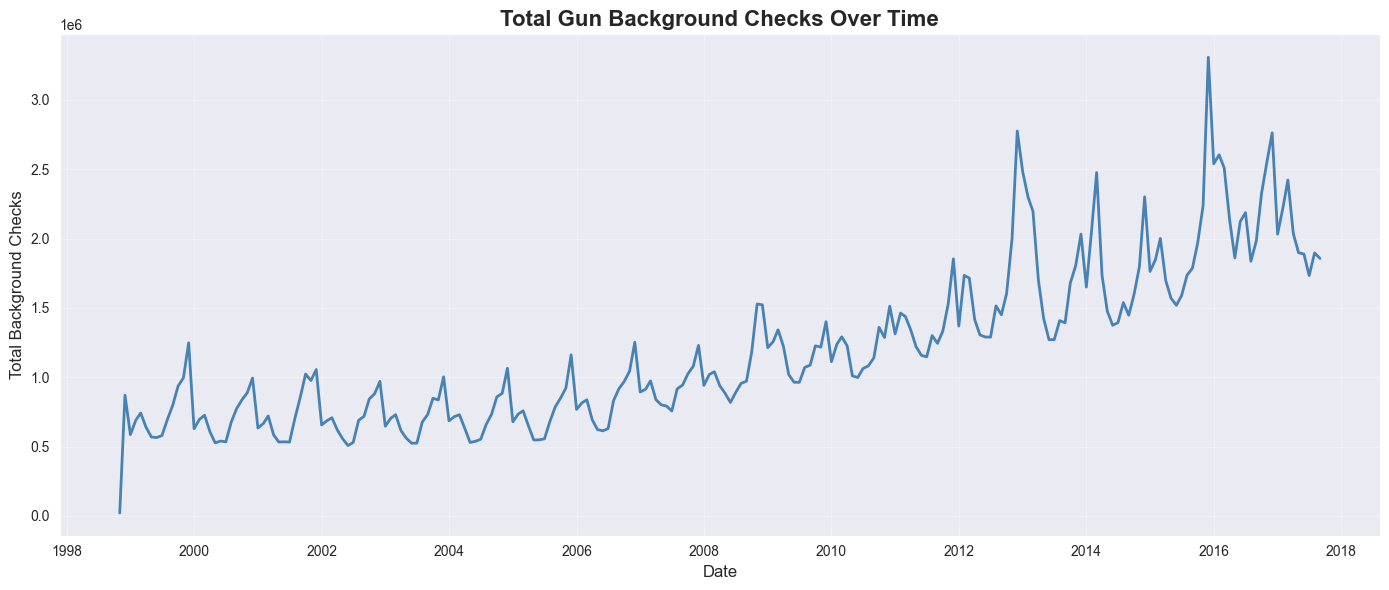

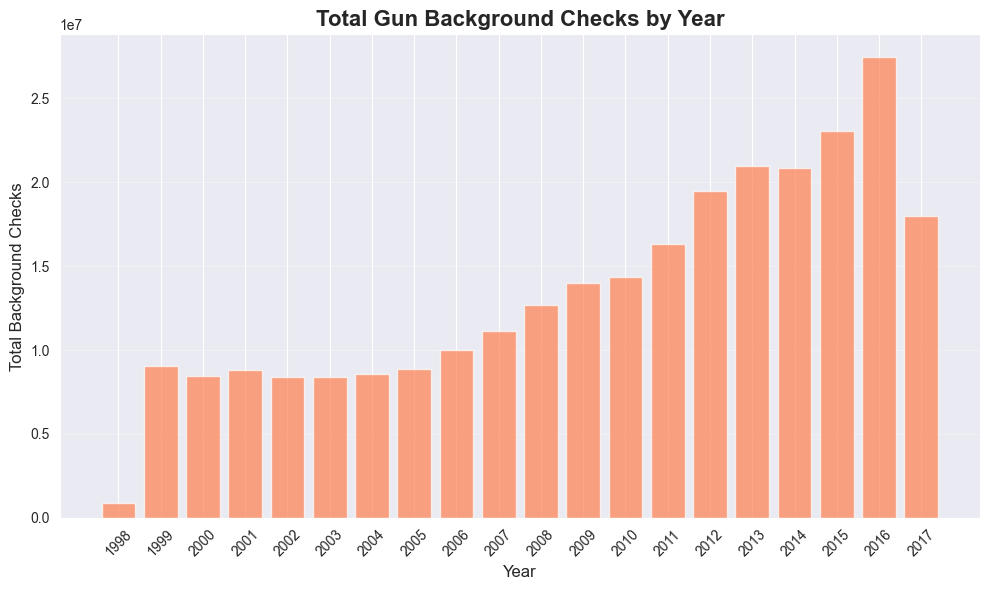


Year-over-Year Growth:
 year   totals  yoy_growth
 1998   891898         NaN
 1999  9043747  913.988931
 2000  8427096   -6.818534
 2001  8820045    4.662923
 2002  8367069   -5.135756
 2003  8402244    0.420398
 2004  8579891    2.114280
 2005  8867055    3.346942
 2006  9993057   12.698715
 2007 11162272   11.700273
 2008 12692985   13.713275
 2009 13984953   10.178599
 2010 14320489    2.399264
 2011 16336732   14.079428
 2012 19463832   19.141527
 2013 20966704    7.721357
 2014 20860241   -0.507772
 2015 23026288   10.383614
 2016 27425512   19.105224
 2017 17990528  -34.402216


In [ ]:
# Aggregate total background checks by month
monthly_totals = df_clean.groupby('month')['totals'].sum().reset_index()
monthly_totals = monthly_totals.sort_values('month')

# Calculate statistics
print("Monthly Background Check Statistics:")
print(f"Mean monthly checks: {monthly_totals['totals'].mean():,.0f}")
print(f"Median monthly checks: {monthly_totals['totals'].median():,.0f}")
print(f"Min monthly checks: {monthly_totals['totals'].min():,.0f}")
print(f"Max monthly checks: {monthly_totals['totals'].max():,.0f}")
print(f"Standard deviation: {monthly_totals['totals'].std():,.0f}")

# Plot 1: Line plot showing trends over time
# Using the reusable function to create a standardized plot
create_labeled_plot(monthly_totals['month'], monthly_totals['totals'],
                   'Total Gun Background Checks Over Time',
                   'Date', 'Total Background Checks',
                   plot_type='line', figsize=(14, 6), color='steelblue')

# Plot 2: Bar plot by year to see annual trends
yearly_totals = df_clean.groupby('year')['totals'].sum().reset_index()

# Using the reusable function for the bar chart
create_labeled_plot(yearly_totals['year'], yearly_totals['totals'],
                   'Total Gun Background Checks by Year',
                   'Year', 'Total Background Checks',
                   plot_type='bar', figsize=(10, 6), color='coral',
                   rotate_x=True, x_rotation=45, grid_axis='y')

# Calculate year-over-year growth
yearly_totals['yoy_growth'] = yearly_totals['totals'].pct_change() * 100
print("\nYear-over-Year Growth:")
print(yearly_totals[['year', 'totals', 'yoy_growth']].to_string(index=False))


### Research Question 2: Which states have the highest and lowest gun background check rates?

Top 10 States by Total Background Checks:
         state   totals
      Kentucky 29762434
         Texas 19435186
    California 19014063
      Illinois 15471534
  Pennsylvania 13133876
       Florida 11695777
          Ohio  8462744
North Carolina  7777689
       Indiana  7737172
     Tennessee  7311293

Bottom 10 States by Total Background Checks:
               state  totals
             Wyoming  894306
            Delaware  491369
             Vermont  484447
        Rhode Island  288870
              Hawaii  197580
         Puerto Rico  194464
      Virgin Islands   15108
                Guam   14997
District of Columbia    5601
     Mariana Islands     462


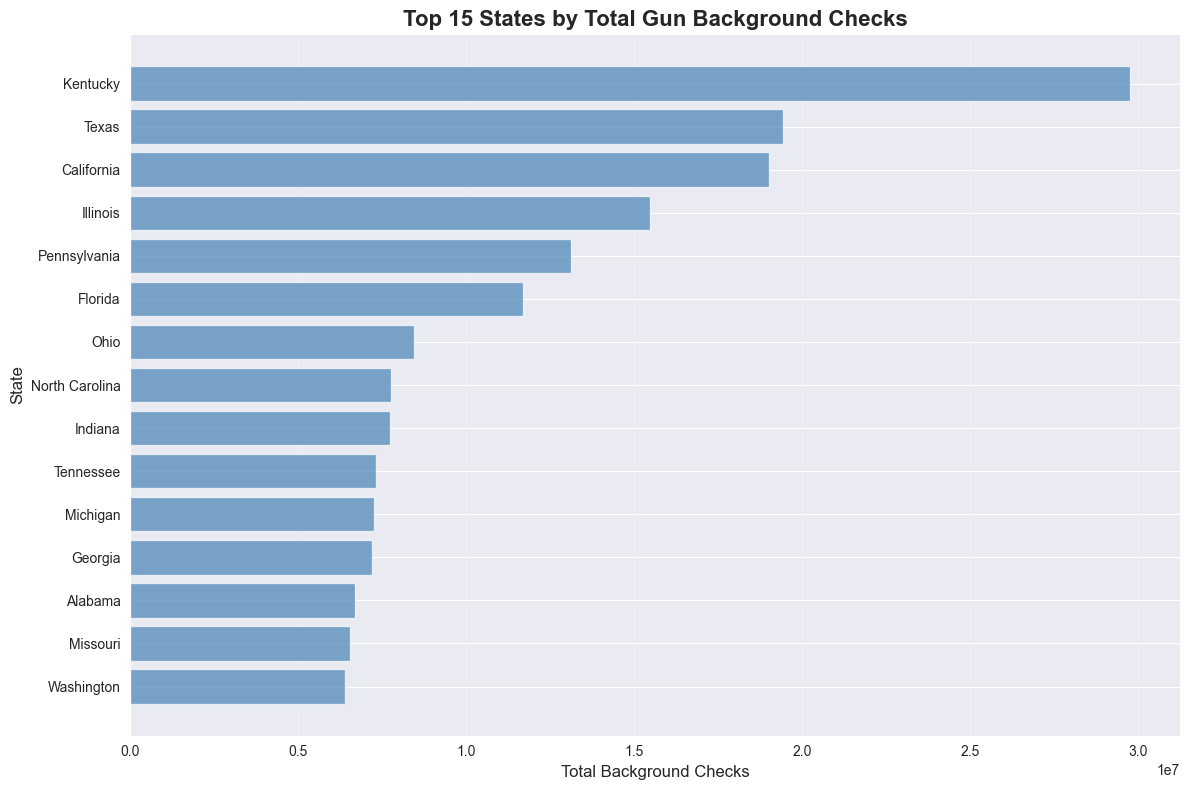

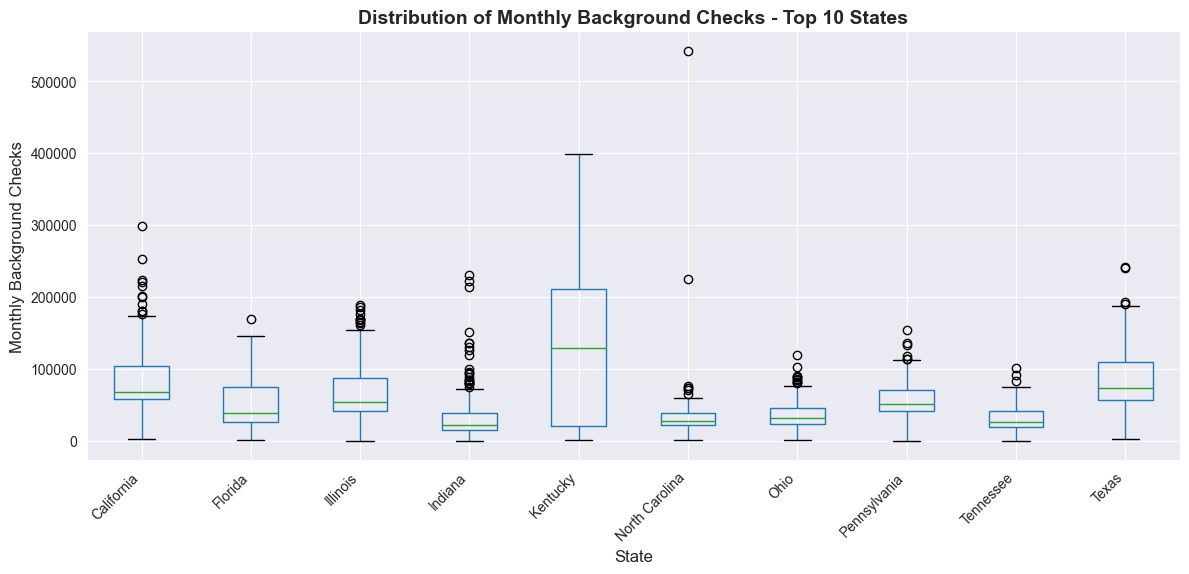


Top 10 States by Average Monthly Background Checks:
         state        totals
      Kentucky 131112.044053
         Texas  85617.559471
    California  83762.392070
      Illinois  68156.537445
  Pennsylvania  57858.484581
       Florida  51523.246696
          Ohio  37280.810573
North Carolina  34262.947137
       Indiana  34084.458150
     Tennessee  32208.339207


In [ ]:
# Aggregate total background checks by state
state_totals = df_clean.groupby('state')['totals'].sum().reset_index()
state_totals = state_totals.sort_values('totals', ascending=False)

# Calculate per-capita rates (using approximate state populations for context)
# Note: This is a simplified analysis - actual per-capita would require population data
print("Top 10 States by Total Background Checks:")
print(state_totals.head(10).to_string(index=False))
print("\nBottom 10 States by Total Background Checks:")
print(state_totals.tail(10).to_string(index=False))

# Plot 1: Horizontal bar chart of top 15 states
top_15 = state_totals.head(15)

# Using the reusable function for horizontal bar chart
create_labeled_plot(top_15['state'], top_15['totals'],
                   'Top 15 States by Total Gun Background Checks',
                   'Total Background Checks', 'State',
                   plot_type='barh', figsize=(12, 8), color='steelblue',
                   grid_axis='x')

# Plot 2: Box plot showing distribution of monthly checks by state (top 10 states)
top_10_states = state_totals.head(10)['state'].tolist()
df_top_states = df_clean[df_clean['state'].isin(top_10_states)]

plt.figure(figsize=(12, 6))
df_top_states.boxplot(column='totals', by='state', ax=plt.gca())
plt.title('Distribution of Monthly Background Checks - Top 10 States', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xlabel('State', fontsize=12)
plt.ylabel('Monthly Background Checks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate average monthly checks per state
state_avg_monthly = df_clean.groupby('state')['totals'].mean().reset_index()
state_avg_monthly = state_avg_monthly.sort_values('totals', ascending=False)
print("\nTop 10 States by Average Monthly Background Checks:")
print(state_avg_monthly.head(10).to_string(index=False))


### Research Question 3: What is the relationship between permits issued and actual gun sales?

Correlation between permits and total sales: 0.201

Permit Statistics:
Mean permits per month: 6,542
Median permits per month: 574
States with permits: 7729 rows

Sales Statistics:
Mean sales per month: 14,033
Median sales per month: 9,174


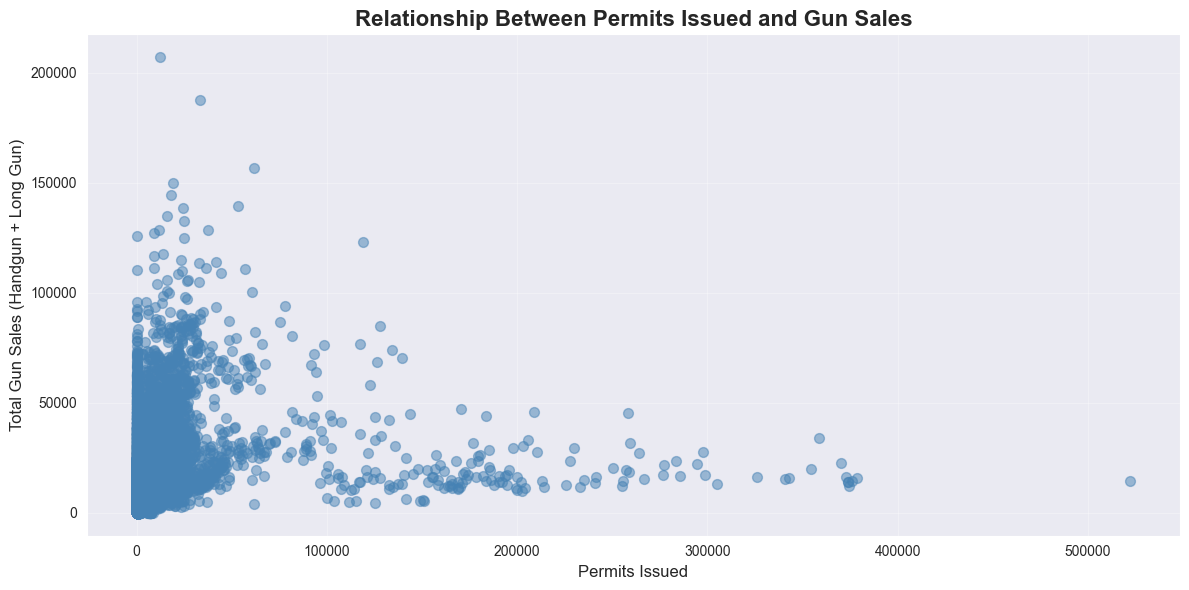


State-level correlation between permits and sales: 0.242


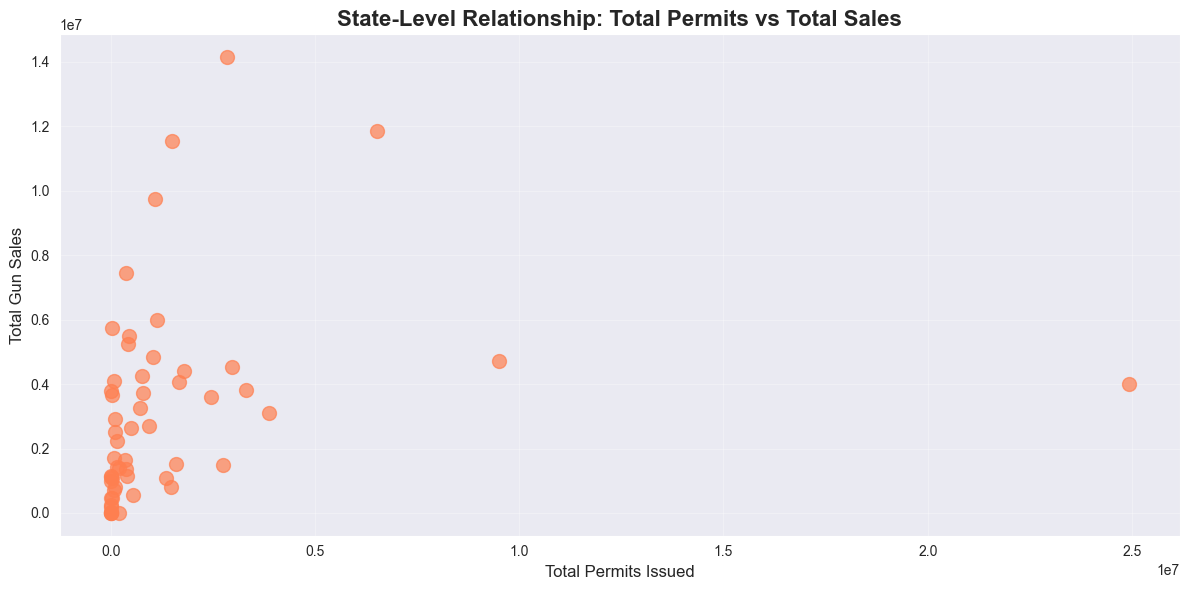

In [ ]:
# Create a combined sales column (handgun + long_gun)
df_clean['total_sales'] = df_clean['handgun'] + df_clean['long_gun']

# Filter out rows where both permit and sales are zero (to avoid division issues)
df_permits_sales = df_clean[(df_clean['permit'] > 0) | (df_clean['total_sales'] > 0)].copy()

# Calculate correlation
correlation = df_permits_sales['permit'].corr(df_permits_sales['total_sales'])
print(f"Correlation between permits and total sales: {correlation:.3f}")

# Statistics
print("\nPermit Statistics:")
print(f"Mean permits per month: {df_permits_sales['permit'].mean():,.0f}")
print(f"Median permits per month: {df_permits_sales['permit'].median():,.0f}")
print(f"States with permits: {(df_permits_sales['permit'] > 0).sum()} rows")

print("\nSales Statistics:")
print(f"Mean sales per month: {df_permits_sales['total_sales'].mean():,.0f}")
print(f"Median sales per month: {df_permits_sales['total_sales'].median():,.0f}")

# Plot 1: Scatter plot of permits vs sales
# Using the reusable function for scatter plot
create_labeled_plot(df_permits_sales['permit'], df_permits_sales['total_sales'],
                   'Relationship Between Permits Issued and Gun Sales',
                   'Permits Issued', 'Total Gun Sales (Handgun + Long Gun)',
                   plot_type='scatter', alpha=0.5, s=50, color='steelblue')

# Plot 2: Aggregate by state to see state-level relationship
state_permits_sales = df_permits_sales.groupby('state').agg({
    'permit': 'sum',
    'total_sales': 'sum'
}).reset_index()

state_correlation = state_permits_sales['permit'].corr(state_permits_sales['total_sales'])
print(f"\nState-level correlation between permits and sales: {state_correlation:.3f}")

# Using the reusable function for the second scatter plot
create_labeled_plot(state_permits_sales['permit'], state_permits_sales['total_sales'],
                   'State-Level Relationship: Total Permits vs Total Sales',
                   'Total Permits Issued', 'Total Gun Sales',
                   plot_type='scatter', alpha=0.7, s=100, color='coral')

Average Background Checks by Month:
month_name       totals
   January 21621.391388
  February 23336.324402
     March 24265.958852
     April 20404.376077
       May 18103.540670
      June 17768.004785
      July 17918.059330
    August 19967.941627
 September 20691.767464
   October 22687.329293
  November 23425.422010
  December 29016.047847


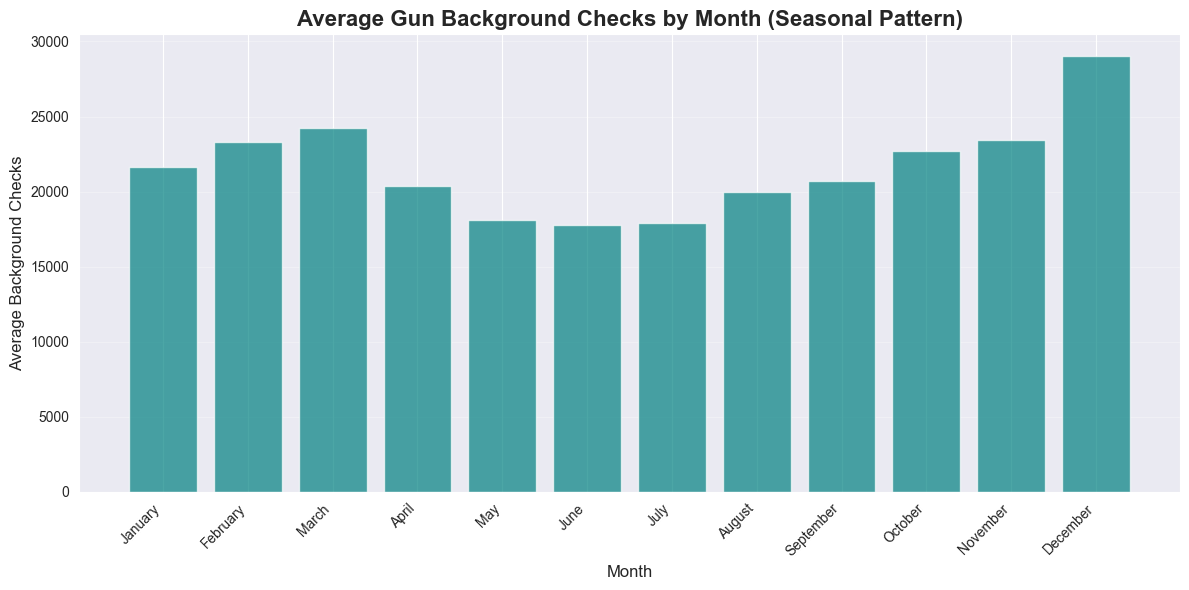

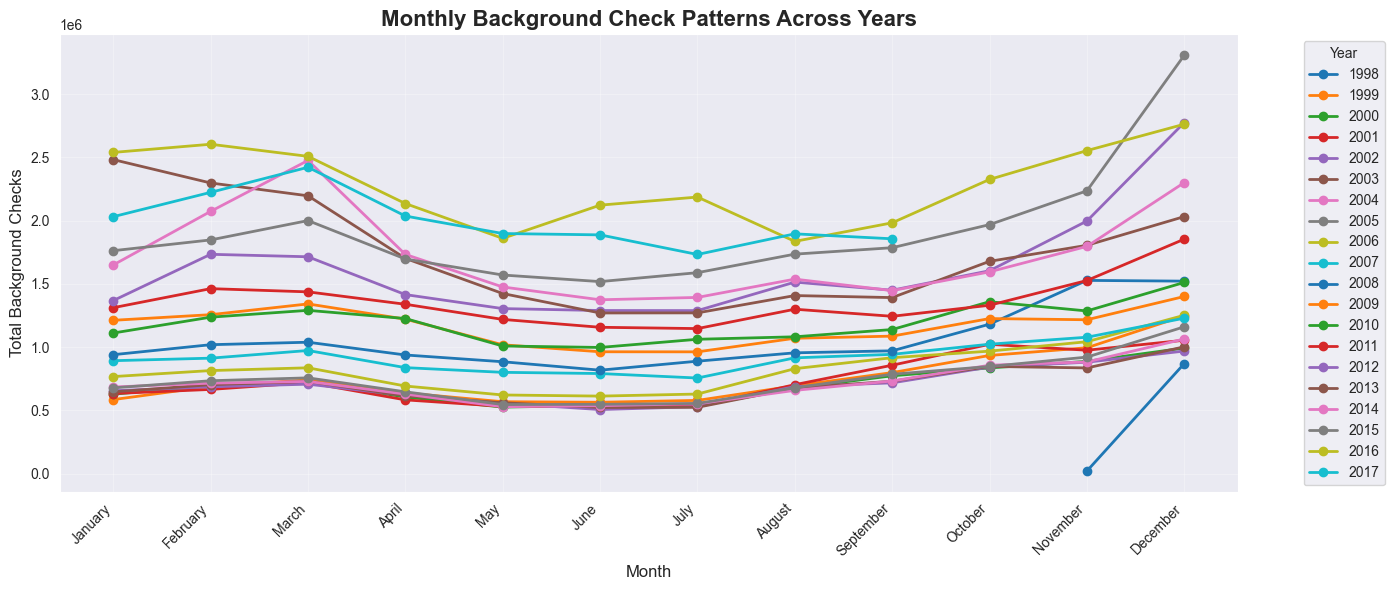


Highest average activity: December
Lowest average activity: June


In [ ]:
# Aggregate by month number to see seasonal patterns
monthly_avg = df_clean.groupby('month_num')['totals'].mean().reset_index()
monthly_avg = monthly_avg.sort_values('month_num')

# Map month numbers to names
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg['month_name'] = monthly_avg['month_num'].map(lambda x: month_names[x-1])

print("Average Background Checks by Month:")
print(monthly_avg[['month_name', 'totals']].to_string(index=False))

# Plot 1: Bar chart showing average checks by month
# Using the reusable function for bar chart
create_labeled_plot(monthly_avg['month_name'], monthly_avg['totals'],
                   'Average Gun Background Checks by Month (Seasonal Pattern)',
                   'Month', 'Average Background Checks',
                   plot_type='bar', color='teal', rotate_x=True,
                   grid_axis='y')

# Plot 2: Line plot showing monthly patterns across years
monthly_by_year = df_clean.groupby(['year', 'month_num'])['totals'].sum().reset_index()
monthly_by_year = monthly_by_year.sort_values(['year', 'month_num'])

# Create a pivot table for easier plotting
pivot_monthly = monthly_by_year.pivot(index='month_num', columns='year', values='totals')

plt.figure(figsize=(14, 6))
for year in pivot_monthly.columns:
    plt.plot(pivot_monthly.index, pivot_monthly[year], marker='o', label=year, linewidth=2)

plt.title('Monthly Background Check Patterns Across Years', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Background Checks', fontsize=12)
plt.xticks(range(1, 13), month_names, rotation=45, ha='right')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate which months have highest/lowest activity
max_month = monthly_avg.loc[monthly_avg['totals'].idxmax(), 'month_name']
min_month = monthly_avg.loc[monthly_avg['totals'].idxmin(), 'month_name']
print(f"\nHighest average activity: {max_month}")
print(f"Lowest average activity: {min_month}")


### Additional Analysis: Gun Type Distribution


Total Background Checks by Gun Type:
handgun     74053083.0
long_gun    97370026.0
other        1982594.0
multiple     3353513.0
dtype: float64

Percentage distribution:
handgun     41.89
long_gun    55.09
other        1.12
multiple     1.90
dtype: float64


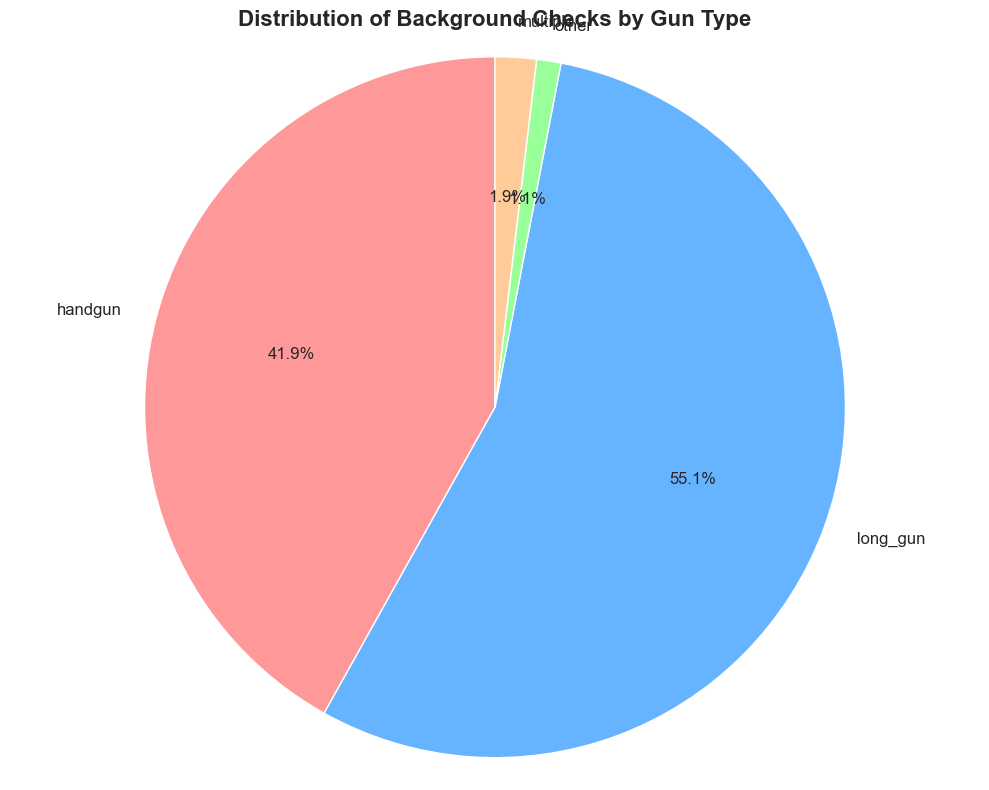

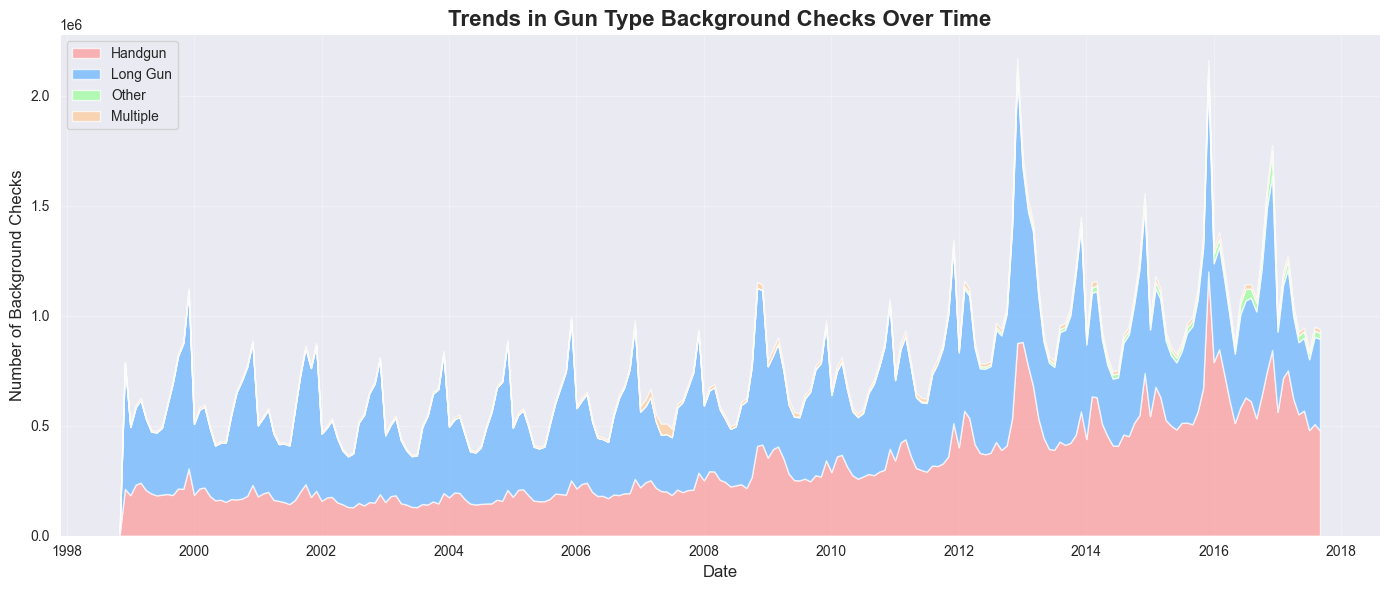

In [8]:
# Analyze distribution of gun types
gun_types = ['handgun', 'long_gun', 'other', 'multiple']
gun_type_totals = df_clean[gun_types].sum()

print("Total Background Checks by Gun Type:")
print(gun_type_totals)
print(f"\nPercentage distribution:")
print((gun_type_totals / gun_type_totals.sum() * 100).round(2))

# Plot: Pie chart of gun type distribution
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(gun_type_totals, labels=gun_type_totals.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Distribution of Background Checks by Gun Type', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot: Stacked area chart showing trends in gun types over time
monthly_gun_types = df_clean.groupby('month')[gun_types].sum().reset_index()
monthly_gun_types = monthly_gun_types.sort_values('month')

plt.figure(figsize=(14, 6))
plt.stackplot(monthly_gun_types['month'], 
              monthly_gun_types['handgun'],
              monthly_gun_types['long_gun'],
              monthly_gun_types['other'],
              monthly_gun_types['multiple'],
              labels=['Handgun', 'Long Gun', 'Other', 'Multiple'],
              colors=colors, alpha=0.7)
plt.title('Trends in Gun Type Background Checks Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Background Checks', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<a id='conclusions'></a>
## Conclusions

### Summary of Findings

1. **Trends Over Time**: The data shows significant variation in gun background checks over time. There appears to be an overall trend, with some years showing higher activity than others. The monthly totals fluctuate, suggesting that external factors (such as political events, policy changes, or public sentiment) may influence background check volumes.

2. **State Variations**: There is substantial variation in background check volumes across states. Some states consistently show much higher numbers than others, which could be due to differences in population size, state regulations, reporting practices, or cultural factors. The top states account for a disproportionately large share of total background checks.

3. **Permits vs Sales Relationship**: The correlation analysis between permits issued and actual gun sales shows a relationship, though it varies by state. Some states have strong permit systems while others may have different regulatory approaches. The scatter plots reveal that while there is a general positive relationship, there are many states with high sales but low permits, or vice versa, indicating that permits are not the only pathway to gun acquisition.

4. **Seasonal Patterns**: The analysis reveals some seasonal patterns in background checks. Certain months consistently show higher or lower activity levels across years. This could be related to hunting seasons, holiday periods, or other cyclical factors that influence gun purchasing behavior.

5. **Gun Type Distribution**: Handguns and long guns dominate the background check data, with handguns typically showing higher numbers. The "other" and "multiple" categories represent smaller portions of the total, but still significant volumes.

### Limitations

1. **Population Normalization**: This analysis does not normalize background check numbers by state population. States with larger populations would naturally be expected to have more background checks. A per-capita analysis would provide more meaningful comparisons between states.

2. **Data Completeness**: The dataset may not include all types of gun transactions, as different states have different reporting requirements and some transactions may not require background checks. Additionally, the data may not capture all states equally if reporting practices vary.

3. **Causation vs Correlation**: This analysis is exploratory and descriptive. No statistical tests for significance were performed, and no causal relationships can be inferred. The correlations observed (such as between permits and sales) do not imply causation.

4. **Temporal Context**: The analysis does not account for major events (such as mass shootings, policy changes, or political events) that might have influenced background check volumes during specific time periods. Understanding these contextual factors would require additional research.

5. **Missing Contextual Data**: The analysis would benefit from additional data sources such as state population figures, state gun laws, crime rates, and economic indicators to provide more comprehensive insights.

### Future Research Directions

- Normalize background check data by state population to enable fairer comparisons
- Investigate the impact of specific events or policy changes on background check volumes
- Analyze the relationship between background checks and crime rates
- Examine regional patterns (e.g., urban vs rural, by geographic region)
- Study the relationship between background check volumes and gun-related incidents
- Investigate the effectiveness of permit systems in different states


## Submitting your Project 

Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should see output that starts with `NbConvertApp] Converting notebook`, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!


In [9]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb


[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1385985 bytes to Investigate_a_Dataset.html
